In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import datetime
import math

In [2]:
#Production data input from La Cabrita
ins_cap= 50
df_prod= pd.read_excel('ES_COLOC_Model_input.xlsx', sheet_name = 'La Cabrita Data')

In [3]:
#Input of Kpler Power Curves (2 Scenarios)
df_price_high = pd.read_excel('ES_COLOC_Model_input.xlsx', sheet_name= 'DA_High')
df_price_cc   = pd.read_excel('ES_COLOC_Model_input.xlsx', sheet_name= 'DA_Central & Crash')
df_price_WM   = pd.read_excel('ES_COLOC_Model_input.xlsx', sheet_name= 'DA_WoodMac')

In [39]:
#Input battery Assumptions

batt_cap = 30
batt_dur = 4
batt_cyc = 1
powerprice_selector = "Central Case"
batt_lifetime = 20
round_eff = 0.85
grid_factor = 0.9                                                      #grid factor to be adjusted based on discussions, to be used for discharge module
soc_max = batt_cap * batt_dur
Grid_cap = ins_cap * grid_factor

In [40]:
#Declaring some variables that are used throughout the code

d1 = datetime.date(2024,1,1)
d2 = datetime.date(2043,12,31)
alldates = pd.date_range(d1, d2).astype('datetime64[ns]')
alldates = alldates[~ ((alldates.month == 2) & (alldates.day == 29))]              # To remove leap days to match with dataset
ref_date = alldates[0]
end_date = alldates[-1]
num_days=len(alldates)
num_hours = num_days * 24

In [41]:
#Merging production with power price data
df_price_high.index == df_prod.index
df_price_cc.index == df_prod.index
df_price_WM.index == df_prod.index
df_price_high['Production (MWh)'] = df_prod['Production (MWh)']
df_price_cc['Production (MWh)'] = df_prod['Production (MWh)']
df_price_WM['Production (MWh)'] = df_prod['Production (MWh)']

In [42]:
#Adding Case Selector for Power Prices

if powerprice_selector == 'High Case':
    df_price_used = df_price_high
elif powerprice_selector == 'Wood Mac':
    df_price_used = df_price_WM    
else: 
    df_price_used = df_price_cc

In [43]:
#Charging Module
k = 1  #k is day counter
l = 1  #Alternate day counter, without this the df_price_short dataframe does not work
df_res_price = pd.DataFrame(np.zeros((num_days, 11)), columns = ['Charge Price_wt', 'Discharge Price_wt', 'SOC Charged' ,'Disc Volume' ,'Max Hour','Day', 'Year', 'Max Hour 24', 'Check', 'Month', 'Month 12'])

for k in range(num_days):
    
    df_price_short = df_price_used.loc[df_price_used['Day'] == l].copy()

# Sorting values by lowest price while also being charge eligible

    df_price_short_sort = df_price_short.loc[df_price_short['Production (MWh)'] > 0].sort_values("Price")
    imax = len(df_price_short_sort)
    
# Initializing the df to zeros in every loop to be able to rewrite
    
    df_soc_mod = pd.DataFrame(np.zeros((18, 4)), columns = ['SOC', 'Price', 'Hour', 'Hour 24'])
    i = 0
    
# SOC calculation Module
   
    while i< imax:
        df_soc_mod['SOC'].iloc[i] = df_price_short_sort['Production (MWh)'].iloc[i]
        df_soc_mod['Price'].iloc[i] = df_price_short_sort['Price'].iloc[i]
        df_soc_mod['Hour'].iloc[i] = df_price_short_sort['Hour'].iloc[i]
        df_soc_mod['Hour 24'].iloc[i] = df_price_short_sort['Hour 24'].iloc[i]
        if df_soc_mod['SOC'].sum() > soc_max:
            df_soc_mod['SOC'].iloc[i] = soc_max - df_soc_mod['SOC'].sum() + df_price_short_sort['Production (MWh)'].iloc[i]
            break  
        i+=1    
        
# Assigning the Results to a Variable
   
    df_res_price['Charge Price_wt'].iloc[k-1] = sum(df_soc_mod['SOC'] * df_soc_mod['Price']) / df_soc_mod['SOC'].sum()
    df_res_price['SOC Charged'].iloc[k-1] = sum(df_soc_mod['SOC'])
    df_res_price['Max Hour'].iloc[k-1] = df_soc_mod['Hour'].max()
    df_res_price['Max Hour 24'].iloc[k-1] = df_soc_mod['Hour 24'].max()
    df_res_price['Day'].iloc[k-1] = df_price_short_sort['Day'].min()
    df_res_price['Year'].iloc[k-1] = df_price_short_sort['Year'].iloc[0]
    df_res_price['Month'].iloc[k-1] = df_price_short_sort['Month Num'].min()
    df_res_price['Month 12'].iloc[k-1] = df_price_short_sort['Month 12'].min()
    
# Readjusting Day Counters 
    
    k+=1
    l+=1  

# The first row always ends up becoming the last, hence the sort by day function is used to correct it. The values remain unchanged and are still correct. 
    
df_res_price = df_res_price.sort_values('Day').reset_index(drop=True)


In [44]:
df_res_price

,Charge Price_wt,Discharge Price_wt,SOC Charged,Disc Volume,Max Hour,Day,Year,Max Hour 24,Check,Month,Month 12
0,47.838734,0.0,120.0,0.0,18.0,1.0,2024.0,18.0,0.0,1.0,1.0
1,83.689601,0.0,120.0,0.0,42.0,2.0,2024.0,18.0,0.0,1.0,1.0
2,80.348791,0.0,120.0,0.0,62.0,3.0,2024.0,14.0,0.0,1.0,1.0
3,76.061073,0.0,120.0,0.0,87.0,4.0,2024.0,15.0,0.0,1.0,1.0
4,86.921166,0.0,120.0,0.0,112.0,5.0,2024.0,16.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7295,11.377807,0.0,120.0,0.0,8656.0,7296.0,2043.0,16.0,0.0,240.0,12.0
7296,4.193967,0.0,120.0,0.0,8681.0,7297.0,2043.0,17.0,0.0,240.0,12.0
7297,6.806222,0.0,120.0,0.0,8704.0,7298.0,2043.0,16.0,0.0,240.0,12.0
7298,5.705285,0.0,120.0,0.0,8729.0,7299.0,2043.0,17.0,0.0,240.0,12.0


In [45]:
df_price_used

,S.No,Date,Hour,Day,Price,Year,Hour 24,Day 365,Month Num,Month 12,Production (MWh)
0,1,2024-01-01,1,1,77.59,2024,1,1,1,1,0.0
1,2,2024-01-01,2,1,96.87,2024,2,1,1,1,0.0
2,3,2024-01-01,3,1,44.25,2024,3,1,1,1,0.0
3,4,2024-01-01,4,1,24.08,2024,4,1,1,1,0.0
4,5,2024-01-01,5,1,27.14,2024,5,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
280315,280316,2055-12-31,8756,11680,85.39,2055,20,365,384,12,0.0
280316,280317,2055-12-31,8757,11680,95.14,2055,21,365,384,12,0.0
280317,280318,2055-12-31,8758,11680,89.50,2055,22,365,384,12,0.0
280318,280319,2055-12-31,8759,11680,89.75,2055,23,365,384,12,0.0


In [46]:
# Discharge Module

m = 0 #Day Counter
r = 1
n = 1 # Second Day Counter

#Assinging a different results variable inorder to avoid any errors or mismatch in results

df_res_price_d = pd.DataFrame(np.zeros((num_days, 5)), columns = ['Discharge Price_wt', 'Disc Volume' ,'End SOC', 'Day', 'Year'])

for m in range(num_days):
    
    z = n+1
    
    df_price_short_d1 = df_price_used.loc[df_price_used['Day'] == n].copy()
    df_price_short_sort_d1 = df_price_short_d1.loc[df_price_short_d1['Hour'] > df_res_price['Max Hour'].iloc[n-1]]
    
    
    df_price_short_d2 = df_price_used.loc[df_price_used['Day'] == z].copy()
    df_price_short_sort_d2 = df_price_short_d2.loc[df_price_short_d2['S.No'] < n*24+5]
    
    df_price_short_d = pd.concat([df_price_short_sort_d1 , df_price_short_sort_d2])
    
    #Sorting Values by the Highest Price Hour that occur after the charging is finished
    
    df_price_short_sort_d = df_price_short_d.sort_values(by = ['Price'], ascending = [False])
    jmax = len(df_price_short_sort_d)
    
    #Initializing the soc control variable to zero
    df_soc_mod_d = pd.DataFrame(np.zeros((18, 3)), columns = ['SOC_avail', 'SOC_disc', 'Price'])
    j = 0
    
    #SOC Calculation Module
    df_soc_mod_d['SOC_avail'].iloc[j] = df_res_price['SOC Charged'].iloc[m] * round_eff
    
    while j < jmax:
        
        if df_soc_mod_d['SOC_avail'].iloc[j] >= batt_cap * round_eff:
            
            if Grid_cap - df_price_short_sort_d['Production (MWh)'].iloc[j] > batt_cap*round_eff:
                df_soc_mod_d['SOC_disc'].iloc[j] = batt_cap*round_eff
                df_soc_mod_d['SOC_avail'].iloc[j+1] = df_soc_mod_d['SOC_avail'].iloc[j] - df_soc_mod_d['SOC_disc'].iloc[j]
                df_soc_mod_d['Price'].iloc[j] = df_price_short_sort_d['Price'].iloc[j]
                
            else: 
                df_soc_mod_d['SOC_disc'].iloc[j] = Grid_cap - df_price_short_sort_d['Production (MWh)'].iloc[j]
                df_soc_mod_d['SOC_avail'].iloc[j+1] = df_soc_mod_d['SOC_avail'].iloc[j] - df_soc_mod_d['SOC_disc'].iloc[j]
                df_soc_mod_d['Price'].iloc[j] = df_price_short_sort_d['Price'].iloc[j]
                
               
        elif ((df_soc_mod_d['SOC_avail'].iloc[j] < batt_cap*round_eff) and (df_soc_mod_d['SOC_avail'].iloc[j] > 0)): 
            
            if Grid_cap - df_price_short_sort_d['Production (MWh)'].iloc[j] > df_soc_mod_d['SOC_avail'].iloc[j] :
                df_soc_mod_d['SOC_disc'].iloc[j] = df_soc_mod_d['SOC_avail'].iloc[j]
                df_soc_mod_d['SOC_avail'].iloc[j+1] = df_soc_mod_d['SOC_avail'].iloc[j] - df_soc_mod_d['SOC_disc'].iloc[j]
                df_soc_mod_d['Price'].iloc[j] = df_price_short_sort_d['Price'].iloc[j]
                
            else: 
                df_soc_mod_d['SOC_disc'].iloc[j] = Grid_cap - df_price_short_sort_d['Production (MWh)'].iloc[j]
                df_soc_mod_d['SOC_avail'].iloc[j+1] = df_soc_mod_d['SOC_avail'].iloc[j] - df_soc_mod_d['SOC_disc'].iloc[j]
                df_soc_mod_d['Price'].iloc[j] = df_price_short_sort_d['Price'].iloc[j]
        
        else:
                        
            break
        
        j+=1
               
    
    #Assinging results to results variable
    
    df_res_price_d['Discharge Price_wt'].iloc[m] = sum(df_soc_mod_d['SOC_disc'] * df_soc_mod_d['Price']) / df_soc_mod_d['SOC_disc'].sum()
    df_res_price_d['End SOC'].iloc[m] = df_soc_mod_d['SOC_avail'].iloc[0] - sum(df_soc_mod_d['SOC_disc'])
    df_res_price_d['Disc Volume'].iloc[m] = sum(df_soc_mod_d['SOC_disc'])
    df_res_price_d['Day'].iloc[m] = df_price_short_sort_d['Day'].min() 
    df_res_price_d['Year'].iloc[m] = df_price_short_sort_d['Year'].min()
    #Recalibrating Day Counters
    
    m+=1
    n+=1
    
# The first row always ends up becoming the last, hence the sort by day function is used to correct it. The values remain unchanged and are still correct. 
    
df_res_price_d = df_res_price_d.sort_values('Day').reset_index(drop=True)

In [47]:
df_price_short_d

,S.No,Date,Hour,Day,Price,Year,Hour 24,Day 365,Month Num,Month 12,Production (MWh)
175192,175193,2043-12-31,8753,7300,23.20,2043,17,365,240,12,7.715666
175193,175194,2043-12-31,8754,7300,32.14,2043,18,365,240,12,2.256139
175194,175195,2043-12-31,8755,7300,48.79,2043,19,365,240,12,0.000000
175195,175196,2043-12-31,8756,7300,42.25,2043,20,365,240,12,0.000000
175196,175197,2043-12-31,8757,7300,56.82,2043,21,365,240,12,0.000000
175197,175198,2043-12-31,8758,7300,60.11,2043,22,365,240,12,0.000000
175198,175199,2043-12-31,8759,7300,58.73,2043,23,365,240,12,0.000000
175199,175200,2043-12-31,8760,7300,53.32,2043,24,365,240,12,0.000000
175200,175201,2044-01-01,1,7301,38.82,2044,1,1,241,1,0.000000
175201,175202,2044-01-01,2,7301,27.84,2044,2,1,241,1,0.000000


In [48]:
#Moving All Results to A Single Variable

df_res_price['Discharge Price_wt'] = df_res_price_d['Discharge Price_wt']
df_res_price['Disc Volume'] = df_res_price_d['Disc Volume']

In [49]:
f = 0

while f < num_days:
   
    if df_res_price['Discharge Price_wt'].iloc[f] * df_res_price['Disc Volume'].iloc[f]  - df_res_price['Charge Price_wt'].iloc[f] * df_res_price['SOC Charged'].iloc[f]< 0:
       
        df_res_price['Charge Price_wt'].iloc[f] = 0
        df_res_price['Discharge Price_wt'].iloc[f] = 0
        df_res_price['SOC Charged'].iloc[f] = 0
        df_res_price['Disc Volume'].iloc[f] = 0
        df_res_price['Max Hour'].iloc[f] = 0
        df_res_price['Check'].iloc[f] = 1
        
    elif df_res_price['Discharge Price_wt'].iloc[f] - df_res_price['Charge Price_wt'].iloc[f] < 0:
        
        df_res_price['Charge Price_wt'].iloc[f] = 0
        df_res_price['Discharge Price_wt'].iloc[f] = 0
        df_res_price['SOC Charged'].iloc[f] = 0
        df_res_price['Disc Volume'].iloc[f] = 0
        df_res_price['Max Hour'].iloc[f] = 0
        df_res_price['Check'].iloc[f] = 1
        
     
    f+=1

    

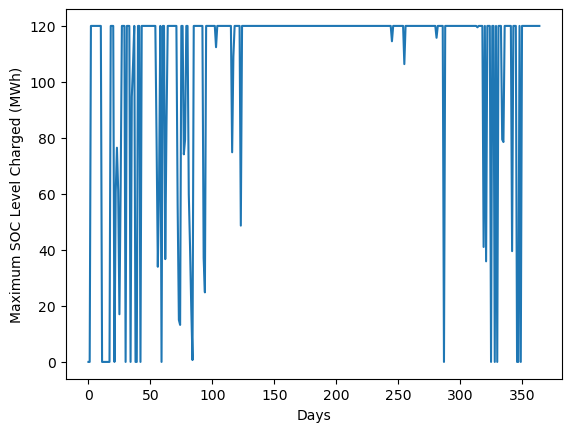

In [50]:
df_res_price['SOC Charged'].head(365).plot()
plt.xlabel("Days")
plt.ylabel("Maximum SOC Level Charged (MWh)")
plt.show()

In [51]:
nochargedays = sum(df_res_price['Check'])/num_days
nochargedays

0.025753424657534246

In [52]:
#Calculating Captured Price Annually

a = 2024
t = 0
df_res_cp = pd.DataFrame(np.zeros((batt_lifetime, 6)), columns = ['Avg Market Price', 'PV Capture Price' ,'PV + BESS Capture Price', 'PV Capture Rate','PV + BESS Capture Rate' , 'Year'])

while a < (batt_lifetime +2024):
  
    df_price_short_cp = df_price_used.loc[df_price_used['Year'] == a].copy()
    df_res_price_short = df_res_price.loc[df_res_price['Year'] == a].copy()
    batt_rev =  sum(df_res_price_short['Discharge Price_wt']*df_res_price_short['Disc Volume']) - sum(df_res_price_short['Charge Price_wt']*df_res_price_short['SOC Charged'])
    
    df_res_cp['Year'].iloc[t] = a
    df_res_cp['Avg Market Price'].iloc[t] = df_price_short_cp['Price'].mean()
    df_res_cp['PV Capture Price'].iloc[t] = sum(df_price_short_cp['Price'] * df_price_short_cp['Production (MWh)'])/sum(df_price_short_cp['Production (MWh)'])
    df_res_cp['PV + BESS Capture Price'].iloc[t] = (sum(df_price_short_cp['Price'] * df_price_short_cp['Production (MWh)']) + batt_rev)/sum(df_price_short_cp['Production (MWh)'])
    df_res_cp['PV Capture Rate'].iloc[t] =  df_res_cp['PV Capture Price'].iloc[t] /  df_res_cp['Avg Market Price'].iloc[t]
    df_res_cp['PV + BESS Capture Rate'].iloc[t] = df_res_cp['PV + BESS Capture Price'].iloc[t] / df_res_cp['Avg Market Price'].iloc[t]
    a+=1
    t+=1

In [53]:
df_res_cp

,Avg Market Price,PV Capture Price,PV + BESS Capture Price,PV Capture Rate,PV + BESS Capture Rate,Year
0,85.884645,52.967166,85.173752,0.616725,0.991723,2024.0
1,77.233977,41.675815,75.129208,0.539605,0.972748,2025.0
2,66.375171,39.054194,64.388419,0.588386,0.970068,2026.0
3,49.027206,25.422157,49.240455,0.518532,1.004350,2027.0
4,41.442446,18.978660,41.946462,0.457952,1.012162,2028.0
5,39.166381,18.166331,39.534881,0.463825,1.009409,2029.0
6,37.625374,17.920465,37.973761,0.476287,1.009259,2030.0
7,35.889277,16.408447,36.102304,0.457196,1.005936,2031.0
8,37.618518,15.826220,37.003779,0.420703,0.983659,2032.0
9,38.644877,16.220354,37.770883,0.419728,0.977384,2033.0


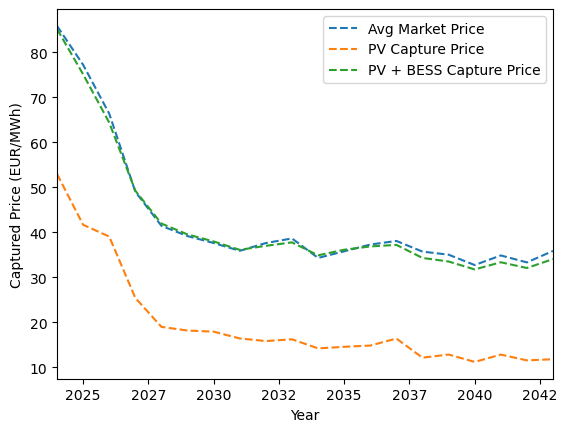

<Figure size 640x480 with 0 Axes>

In [54]:
plot1 = df_res_cp.plot(x= 'Year' , y = ['Avg Market Price', 'PV Capture Price', 'PV + BESS Capture Price'], linestyle = 'dashed')
plot1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#plt.title('Espuna - Herrera Capture Price Analysis')
#plt.axis('tight')
plt.ylabel("Captured Price (EUR/MWh)")
plt.xlim(2024,2043)
plt.show()
plt.savefig('Capture Price')

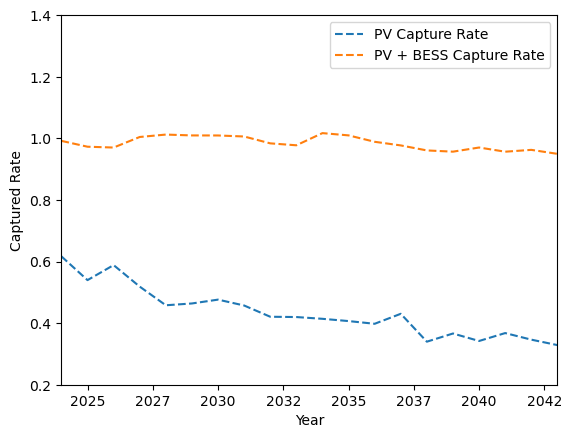

<Figure size 640x480 with 0 Axes>

In [55]:
plot2 = df_res_cp.plot(x= 'Year' , y = ['PV Capture Rate', 'PV + BESS Capture Rate'], linestyle = 'dashed')
plot2.xaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.ylabel("Captured Rate")
plt.ylim(0.2,1.4);
plt.xlim(2024,2043)
plt.show()
plt.savefig('Capture Rate')

<Axes: >

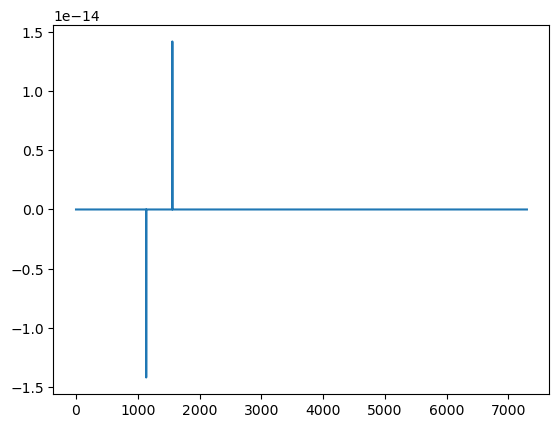

In [56]:
df_res_price_d['End SOC'].plot()

In [57]:
df_res_price

,Charge Price_wt,Discharge Price_wt,SOC Charged,Disc Volume,Max Hour,Day,Year,Max Hour 24,Check,Month,Month 12
0,0.000000,0.000000,0.0,0.0,0.0,1.0,2024.0,18.0,1.0,1.0,1.0
1,0.000000,0.000000,0.0,0.0,0.0,2.0,2024.0,18.0,1.0,1.0,1.0
2,80.348791,115.545000,120.0,102.0,62.0,3.0,2024.0,14.0,0.0,1.0,1.0
3,76.061073,106.217797,120.0,102.0,87.0,4.0,2024.0,15.0,0.0,1.0,1.0
4,86.921166,125.682500,120.0,102.0,112.0,5.0,2024.0,16.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7295,11.377807,98.282500,120.0,102.0,8656.0,7296.0,2043.0,16.0,0.0,240.0,12.0
7296,4.193967,66.782500,120.0,102.0,8681.0,7297.0,2043.0,17.0,0.0,240.0,12.0
7297,6.806222,53.407500,120.0,102.0,8704.0,7298.0,2043.0,16.0,0.0,240.0,12.0
7298,5.705285,55.280000,120.0,102.0,8729.0,7299.0,2043.0,17.0,0.0,240.0,12.0


<Axes: >

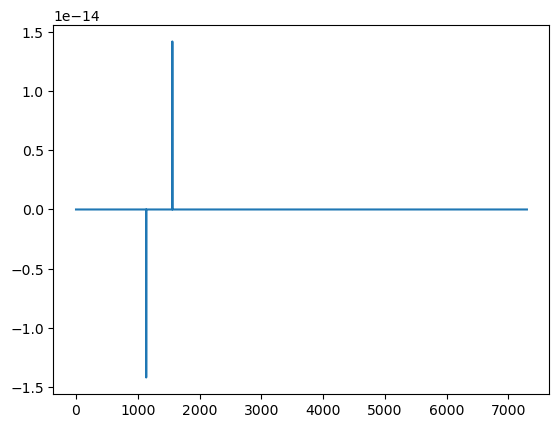

In [58]:
EndSOC_check = df_res_price['SOC Charged'] * round_eff - df_res_price['Disc Volume']
EndSOC_check.plot()

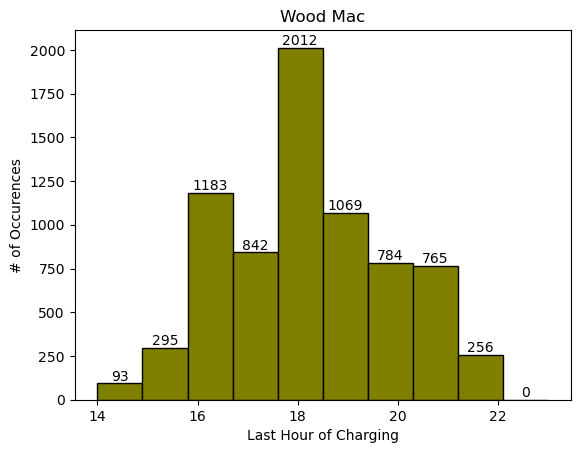

In [59]:
n, bins, patches = plt.hist(df_res_price['Max Hour 24'], range = [14,23], color = 'Olive', ec = 'black')
plt.xlabel('Last Hour of Charging')
plt.ylabel('# of Occurences')
plt.title('Wood Mac')
plt.grid(False)
plt.bar_label(patches)
plt.show()

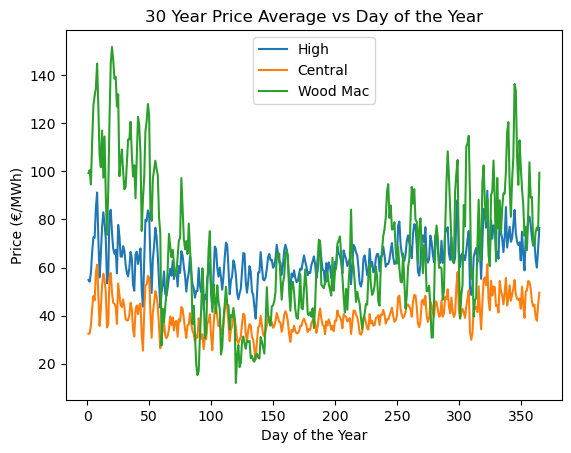

In [60]:
a = df_price_high['Price'].groupby(df_price_high['Day 365']).mean()
b = df_price_cc['Price'].groupby(df_price_cc['Day 365']).mean()
c = df_price_WM['Price'].groupby(df_price_WM['Day 365']).mean()

a.plot(label = 'High')
b.plot(label = 'Central')
c.plot(label = 'Wood Mac')

plt.legend()
plt.xlabel('Day of the Year')
plt.ylabel('Price (€/MWh)')
plt.title('30 Year Price Average vs Day of the Year')
plt.show()


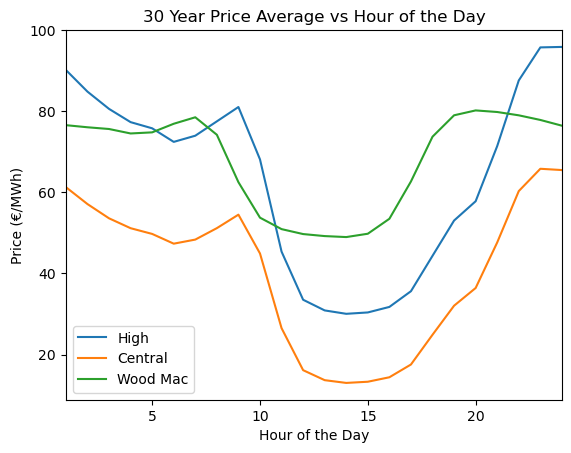

In [61]:
f = df_price_high['Price'].groupby(df_price_high['Hour 24']).mean()
e = df_price_cc['Price'].groupby(df_price_cc['Hour 24']).mean()
g = df_price_WM['Price'].groupby(df_price_WM['Hour 24']).mean()
f.plot(label = 'High')
e.plot(label = 'Central')
g.plot(label = 'Wood Mac')

plt.legend()
plt.axis('Tight')
plt.xlim(1,24)
plt.xlabel('Hour of the Day')
plt.ylabel('Price (€/MWh)')
plt.title('30 Year Price Average vs Hour of the Day')
plt.show()

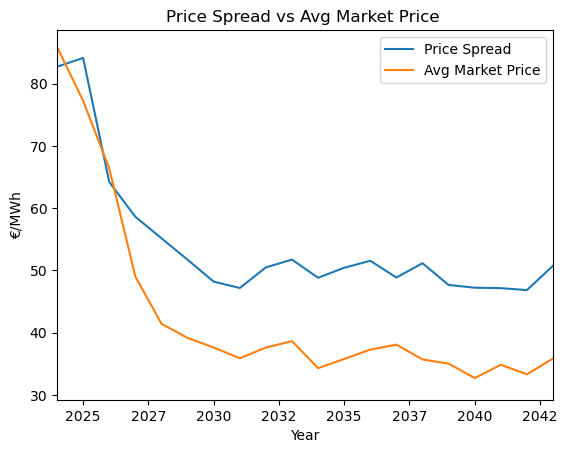

In [62]:
price_delta = df_res_price['Discharge Price_wt'] - df_res_price['Charge Price_wt']
price_delta_plot = price_delta.groupby(df_res_price['Year']).mean().plot(label = 'Price Spread')
df_price_used['Price'].groupby(df_price_used['Year']).mean().plot(label = 'Avg Market Price')
price_delta_plot.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.axis('tight')
plt.title('Price Spread vs Avg Market Price ')
plt.xlim(2024, 2043)
plt.legend()
plt.ylabel('€/MWh')
plt.show()

(2024.0, 2050.0)

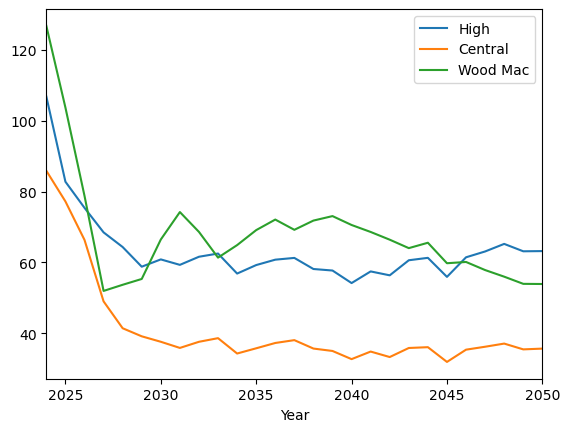

In [63]:
high = df_price_high['Price'].groupby(df_price_high['Year']).mean().plot(label = 'High')
cc   = df_price_cc['Price'].groupby(df_price_cc['Year']).mean().plot(label = 'Central')
WM   = df_price_WM['Price'].groupby(df_price_WM['Year']).mean().plot(label = 'Wood Mac')
plt.legend()
plt.xlim(2024,2050)

In [64]:
df_res_price

,Charge Price_wt,Discharge Price_wt,SOC Charged,Disc Volume,Max Hour,Day,Year,Max Hour 24,Check,Month,Month 12
0,0.000000,0.000000,0.0,0.0,0.0,1.0,2024.0,18.0,1.0,1.0,1.0
1,0.000000,0.000000,0.0,0.0,0.0,2.0,2024.0,18.0,1.0,1.0,1.0
2,80.348791,115.545000,120.0,102.0,62.0,3.0,2024.0,14.0,0.0,1.0,1.0
3,76.061073,106.217797,120.0,102.0,87.0,4.0,2024.0,15.0,0.0,1.0,1.0
4,86.921166,125.682500,120.0,102.0,112.0,5.0,2024.0,16.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7295,11.377807,98.282500,120.0,102.0,8656.0,7296.0,2043.0,16.0,0.0,240.0,12.0
7296,4.193967,66.782500,120.0,102.0,8681.0,7297.0,2043.0,17.0,0.0,240.0,12.0
7297,6.806222,53.407500,120.0,102.0,8704.0,7298.0,2043.0,16.0,0.0,240.0,12.0
7298,5.705285,55.280000,120.0,102.0,8729.0,7299.0,2043.0,17.0,0.0,240.0,12.0


In [65]:
#Calculating Captured Price monthly

b = df_res_price['Month'].min()
bmax = df_res_price['Month'].max()
diff = bmax - b +1
t = 0
df_res_cp_m = pd.DataFrame(np.zeros((int(diff), 8)), columns = ['Avg Market Price', 'PV Capture Price' ,'PV + BESS Capture Price', 'PV Capture Rate','PV + BESS Capture Rate' , 'Month', 'Month 12' ,'Year'])

while b < (bmax+1):
  
    df_price_short_cp = df_price_used.loc[df_price_used['Month Num'] == b].copy()
    df_res_price_short = df_res_price.loc[df_res_price['Month'] == b].copy()
    batt_rev =  sum(df_res_price_short['Discharge Price_wt']*df_res_price_short['Disc Volume']) - sum(df_res_price_short['Charge Price_wt']*df_res_price_short['SOC Charged'])
    
    df_res_cp_m['Month'].iloc[t] = b 
    df_res_cp_m['Month 12'].iloc[t] = df_price_short_cp['Month 12'].min()
    df_res_cp_m['Year'].iloc[t] = df_price_short_cp['Year'].min()
    df_res_cp_m['Avg Market Price'].iloc[t] = df_price_short_cp['Price'].mean()
    df_res_cp_m['PV Capture Price'].iloc[t] = sum(df_price_short_cp['Price'] * df_price_short_cp['Production (MWh)'])/sum(df_price_short_cp['Production (MWh)'])
    df_res_cp_m['PV + BESS Capture Price'].iloc[t] = (sum(df_price_short_cp['Price'] * df_price_short_cp['Production (MWh)']) + batt_rev)/sum(df_price_short_cp['Production (MWh)'])
    df_res_cp_m['PV Capture Rate'].iloc[t] =  df_res_cp_m['PV Capture Price'].iloc[t] /  df_res_cp_m['Avg Market Price'].iloc[t]
    df_res_cp_m['PV + BESS Capture Rate'].iloc[t] = df_res_cp_m['PV + BESS Capture Price'].iloc[t] / df_res_cp_m['Avg Market Price'].iloc[t]
    b+=1
    t+=1

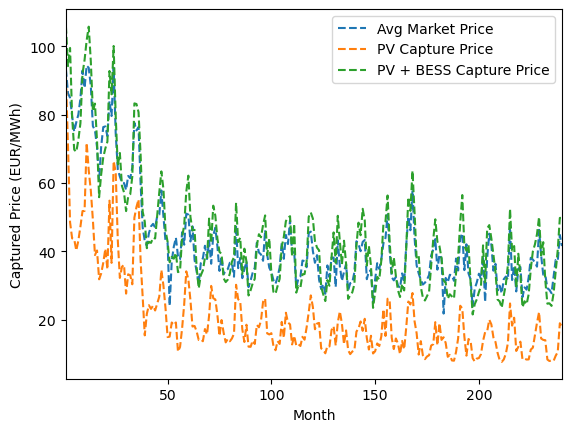

<Figure size 640x480 with 0 Axes>

In [66]:
plot1 = df_res_cp_m.plot(x= 'Month' , y = ['Avg Market Price', 'PV Capture Price', 'PV + BESS Capture Price'], linestyle = 'dashed')
plot1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#plt.axis('tight')
plt.ylabel("Captured Price (EUR/MWh)")
plt.xlim(1,bmax)
plt.show()
plt.savefig('Capture Price')

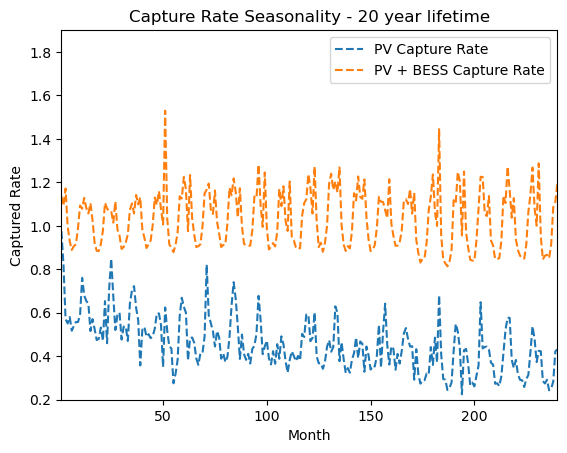

<Figure size 640x480 with 0 Axes>

In [67]:
plot2 = df_res_cp_m.plot(x= 'Month' , y = ['PV Capture Rate', 'PV + BESS Capture Rate'], linestyle = 'dashed')
plot2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.title("Capture Rate Seasonality - 20 year lifetime")
plt.ylabel("Captured Rate")
plt.axis('tight')
plt.ylim(0.2,1.9);
plt.xlim(1,bmax)
plt.show()
plt.savefig('Capture Rate')

In [68]:
df_res_cp_m.head(25)

,Avg Market Price,PV Capture Price,PV + BESS Capture Price,PV Capture Rate,PV + BESS Capture Rate,Month,Month 12,Year
0,93.373414,90.977197,105.988900,0.974337,1.135108,1.0,1.0,2024.0
1,86.299673,70.926861,94.228131,0.821867,1.091871,2.0,2.0,2024.0
2,84.971945,48.527958,99.545078,0.571106,1.171505,3.0,3.0,2024.0
3,79.518917,43.802406,79.369390,0.550843,0.998120,4.0,4.0,2024.0
4,75.059664,43.579131,69.774653,0.580593,0.929589,5.0,5.0,2024.0
5,77.780639,40.252795,69.144588,0.517517,0.888969,6.0,6.0,2024.0
6,80.055995,43.175111,72.594812,0.539311,0.906800,7.0,7.0,2024.0
7,84.770766,47.265760,77.554391,0.557571,0.914872,8.0,8.0,2024.0
8,92.910806,51.788843,91.973302,0.557404,0.989910,9.0,9.0,2024.0
9,87.854933,51.821564,96.060417,0.589854,1.093398,10.0,10.0,2024.0


In [69]:
delta = df_res_cp_m['PV + BESS Capture Rate'] - df_res_cp_m['PV Capture Rate']

<Axes: >

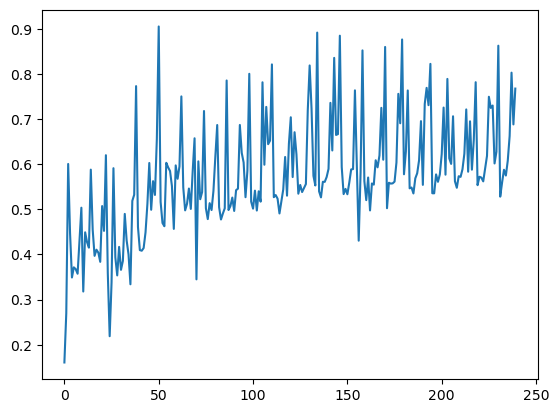

In [70]:
delta.plot()

In [71]:
df_price_short_sort

,S.No,Date,Hour,Day,Price,Year,Hour 24,Day 365,Month Num,Month 12,Production (MWh)
175189,175190,2043-12-31,8750,7300,21.88,2043,14,365,240,12,29.408748
175187,175188,2043-12-31,8748,7300,22.81,2043,12,365,240,12,25.502267
175191,175192,2043-12-31,8752,7300,22.88,2043,16,365,240,12,17.401094
175186,175187,2043-12-31,8747,7300,22.95,2043,11,365,240,12,18.204235
175190,175191,2043-12-31,8751,7300,22.95,2043,15,365,240,12,27.472029
175188,175189,2043-12-31,8749,7300,22.99,2043,13,365,240,12,26.757004
175192,175193,2043-12-31,8753,7300,23.20,2043,17,365,240,12,7.715666
175193,175194,2043-12-31,8754,7300,32.14,2043,18,365,240,12,2.256139
175185,175186,2043-12-31,8746,7300,34.05,2043,10,365,240,12,7.836825
175184,175185,2043-12-31,8745,7300,39.67,2043,9,365,240,12,0.275363


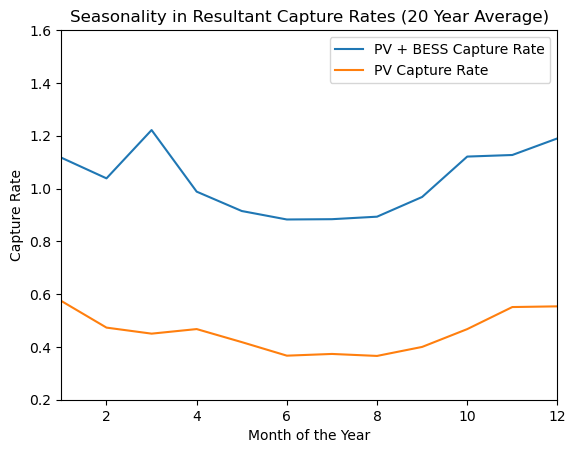

In [72]:
x = df_res_cp_m['PV + BESS Capture Rate'].groupby(df_res_cp_m['Month 12']).mean()
y = df_res_cp_m['PV Capture Rate'].groupby(df_res_cp_m['Month 12']).mean()

x.plot(label = 'PV + BESS Capture Rate')
y.plot(label = 'PV Capture Rate')

plt.legend()
plt.axis('Tight')
plt.xlim(1,12)
plt.ylim(0.2,1.6)
plt.xlabel('Month of the Year')
plt.ylabel('Capture Rate')
plt.title('Seasonality in Resultant Capture Rates (20 Year Average)')
plt.show()

In [73]:
df_res_cp.to_excel('Standalone results 2Hr.xlsx', sheet_name = "10_WM")